In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py
plt.rcParams.update({'text.usetex': True})

# design reverse integrability

In [2]:
fname="./simulations/pouliasis2017pii/numericalErrorExperiment/NGC6171_stream_NSTEPS_4096_NP_512_retrace.hdf5"
myfile= h5py.File(fname, 'r')

In [3]:
comptimeretrace = myfile['comptimeretrace'][()]
print("comptimeorbit", myfile['comptimeorbit'][()])
print("comptimestream", myfile['comptimestream'][()])
print("comptimeretrace", myfile['comptimeretrace'][()])
stream_retrace = myfile['stream_retrace'][:]
streamfinal = myfile['streamfinal'][:]
streaminitial = myfile['streaminitial'][:]
hostorbit = myfile['hostorbit'][:]
streaminitial = streaminitial + hostorbit[:,0][:, np.newaxis]
integrationparameters = myfile.attrs['integrationparameters']
hostparams = myfile.attrs['hostparams']
staticgalaxy = myfile.attrs['potentialname'],myfile.attrs['potentialparams']
GCname = myfile.attrs['GCname']

comptimeorbit 0.00917
comptimestream 0.652214
comptimeretrace 0.607935


In [4]:
dt = integrationparameters[1]
tau=np.sqrt(hostparams[2]**3/(hostparams[0]*hostparams[1]))
alpha = dt/tau
alpha
# Calculate the number of timesteps per dynamical time
n_steps_per_tau = tau / dt

# Format alpha (dt/tau) in scientific notation
mantissa =  10**(int(np.floor(np.log10(abs(alpha)))))
exponent = int(np.floor(np.log10(abs(alpha))))
alpha_formatted = r"${:.1f} \times 10^{{{}}}$".format(mantissa*10, exponent-1)

print(f"Timestep: dt = {dt}")
print(f"Dynamical time: τ = {tau:.5f}")
print(f"Number of steps per dynamical time: {n_steps_per_tau:.1f}")
print(f"Ratio dt/τ = {alpha_formatted}")

boost = 1
matissa = 10**(np.log10(alpha) - int(np.log10(alpha)) + boost)
exponent = int(np.log10(alpha)) - boost
alpha_formatted = r"$\Delta t = {:.1f} \times 10^{{{}}} \tau$".format(matissa, exponent)
print(f"Boosted ratio dt/τ = {alpha_formatted}")
text_comp_time = r"$\mathrm{{Comp~time}} = {:.2f}~\mathrm{{s}}$".format(comptimeretrace)
integrationtime=integrationparameters[-1]*integrationparameters[1]
NSTEPS = int(integrationparameters[-1])
integrationtime=integrationtime*(u.s * (u.kpc/u.km))
integrationtime = integrationtime.to(u.Myr)
text_integration_time = r"$\mathrm{{T}} = {:.0f}~\mathrm{{Myr}}$".format(integrationtime.value)
print(text_comp_time)
print(text_integration_time)
image_name = "NumericalErrorStreamRetrace_{:s}_Nsteps_{:d}_stepsPerTau_{:d}.png".format(GCname, NSTEPS, int(n_steps_per_tau))

Timestep: dt = 0.000244140625
Dynamical time: τ = 0.00030
Number of steps per dynamical time: 1.2
Ratio dt/τ = $1.0 \times 10^{-2}$
Boosted ratio dt/τ = $\Delta t = 8.2 \times 10^{-1} \tau$
$\mathrm{Comp~time} = 0.61~\mathrm{s}$
$\mathrm{T} = 978~\mathrm{Myr}$


In [5]:
phiMW0, phiHost0, T0 = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], streaminitial)
phiMWstream, phiHoststream, Tstream = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,-1], streamfinal)
phiMWR, phiHostR, TR = STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], stream_retrace)
E0 = phiMW0 + phiHost0 + T0
Estream = phiMWstream + phiHoststream + Tstream
ER = phiMWR + phiHostR + TR

errEFinal = np.abs((Estream - E0)/E0)
errERetrace = np.abs((ER - E0)/E0)

print(f"Energy error in stream retrace: {np.mean(errERetrace):.2e}")

Energy error in stream retrace: 2.45e-03


In [6]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Accent.colors)

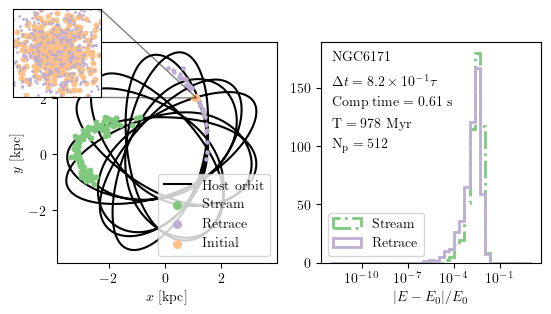

In [88]:
# fig,axis= plt.subplots(1,1,figsize=((8.25-2),(8.25-2)/2))
fig = plt.figure(figsize=(8.25-2, 4.5))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
axis = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], )
axis.plot(hostorbit[0,6:], hostorbit[1,6:], 'k-',                   label=r'$\mathrm{Host~orbit}$',zorder=0)
scatStream=axis.scatter(streamfinal[0], streamfinal[1], s=10,       label=r'$\mathrm{Stream}$')
scatRetrace=axis.scatter(stream_retrace[0], stream_retrace[1], s=5, label=r'$\mathrm{Retrace}$')
scatInit=axis.scatter(streaminitial[0],  streaminitial[1], s=10,    label=r'$\mathrm{Initial}$')
# Also make markers in the inset legend bigger if needed
xymin = np.min([axis.get_xlim()[0], axis.get_ylim()[0]])
xymax = np.max([axis.get_xlim()[1], axis.get_ylim()[1]])
axis.set_xlim(xymin, xymax)
axis.set_ylim(xymin, xymax)

# add a subplot that zooms on the retrace positions
axins = axis.inset_axes([-0.2, 0.75, 0.4, 0.4])  # [x0, y0, width, height]
axins.scatter(streaminitial[0],   streaminitial[1], s=10, c=scatInit.get_edgecolor())
axins.scatter(stream_retrace[0], stream_retrace[1], s=1, c=scatRetrace.get_edgecolor())
axins.set_aspect('equal', adjustable='box')
# Add indicator lines from the main plot to the inset
axis.indicate_inset_zoom(axins, edgecolor="black")
# only do a couple characteristic radii
hostparams[-1]
radius = 2*hostparams[-1]
axins.set_xlim(hostorbit[0,0] + - radius, hostorbit[0,0]  + radius)
axins.set_ylim(hostorbit[1,0] + - radius, hostorbit[1,0]  + radius)
axins.set_xticks([])
axins.set_yticks([])

# Make markers in legend bigger
axis.legend(loc='lower right')
axis.set_aspect('equal', )
axis.set_xlabel(r'$x~[\mathrm{kpc}]$')
axis.set_ylabel(r'$y~[\mathrm{kpc}]$')
legend = axis.legend(loc='lower right')
for handle in legend.legend_handles:
    handle._sizes = [30]


bins = np.logspace(-12,1,40)
ax2.hist(errEFinal,bins=bins, histtype='step', color=scatStream.get_facecolor(), lw=2, label=r'$\mathrm{Stream}$', linestyle='-.');
ax2.hist(errERetrace,bins=bins, histtype='step', color=scatRetrace.get_facecolor(), lw=2, label=r'$\mathrm{Retrace}$', linestyle='-');
ax2.set_xscale('log')

ax2.set_xlabel(r'$|E - E_0| / E_0$')
ax2.legend(loc="lower left")

# Make sure ax2 has the same height as axis
ax2.set_position([ax2.get_position().x0, 
                 axis.get_position().y0, 
                 ax2.get_position().width, 
                 axis.get_position().height])
ax2.text(0.05, 0.9, r"$\mathrm{{{:s}}}$".format(GCname), transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.8, alpha_formatted, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.7, text_comp_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.6, text_integration_time, transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")
ax2.text(0.05, 0.5, r"$\mathrm{{N}}_\mathrm{{p}} = {:d}$".format(int(streamfinal.shape[1])), transform=ax2.transAxes, ha='left', va='bottom', fontsize="medium")

fig.savefig("../../images/"+image_name, bbox_inches='tight', dpi=300)

# Get the over all accuracy 

In [89]:
meanErrEs=[]
NSTEPS=[]
alphas=[]

indir = "./simulations/pouliasis2017pii/numericalErrorExperiment/"
fnames = os.listdir(indir)
for fname in fnames:
    with h5py.File(indir + fname, 'r') as myfile:
        stream_retrace = myfile['stream_retrace'][:]
        streamfinal = myfile['streamfinal'][:]
        streaminitial = myfile['streaminitial'][:]
        hostorbit = myfile['hostorbit'][:]


        streaminitial = streaminitial + hostorbit[:,0][:, np.newaxis]
        try :
            integrationparameters = myfile.attrs['integrationparameters']
        except KeyError:
            print(f"Skipping {fname} due to missing integration parameters.")
            continue
        
        hostparams = myfile.attrs['hostparams']
        staticgalaxy = myfile.attrs['potentialname'],myfile.attrs['potentialparams']
        try: 
            GCname = myfile.attrs['GCname']
        except KeyError:
            print(f"Skipping {fname} due to missing GC name.")
            continue
        

        dt = integrationparameters[1]
        tau=np.sqrt(hostparams[2]**3/(hostparams[0]*hostparams[1]))
        alpha = dt/tau
        NSTEP = int(integrationparameters[-1])

        phiMW,phiGC,T=STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], streaminitial)
        E0= phiMW + phiGC + T
        phiMWR,phiGCR,TR=STR.compute_stream_energy(staticgalaxy[1], hostparams, hostorbit[:,0], stream_retrace)
        ER = phiMWR + phiGCR + TR
        errE = np.abs((ER - E0)/E0)
        meanErrE = np.mean(errE)

        meanErrEs.append(meanErrE)
        alphas.append(alpha)
        NSTEPS.append(NSTEP)

NSTEPS = np.array(NSTEPS)
alphas = np.array(alphas)
meanErrEs = np.array(meanErrEs)

Skipping NGC6304_stream_NSTEPS_8192_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6218_stream_NSTEPS_4096_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC2808_stream_NSTEPS_16384_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6569_stream_NSTEPS_8192_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping Pal10_stream_NSTEPS_2048_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC104_stream_NSTEPS_8192_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6273_stream_NSTEPS_8192_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6864_stream_NSTEPS_16384_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6440_stream_NSTEPS_16384_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping NGC6402_stream_NSTEPS_8192_NP_512_retrace.hdf5 due to missing integration parameters.
Skipping Gran1_stream_NSTEPS_1024_NP_512_retrace.h

In [90]:
# lets do a least squares fit to the log of the
logNPSTEPS = np.log10(NSTEPS)
logALPHAS = np.log10(alphas)
logMEANERR = np.log10(meanErrEs)
A = np.vstack([np.ones_like(logNPSTEPS), logNPSTEPS, logALPHAS]).T
coeffs, residuals, rank, s = np.linalg.lstsq(A, logMEANERR, rcond=None)
logA, alpha, beta = coeffs

# Estimate variance of residuals
n = len(logMEANERR)
p = A.shape[1]
res_var = residuals[0] / (n - p) if residuals.size > 0 else 0

# Covariance matrix of coefficients
cov = res_var * np.linalg.inv(A.T @ A)
errors = np.sqrt(np.diag(cov))

logA_err, alpha_err, beta_err = errors

print(f"Fit: C = 10^{logA:.2f} ± {logA_err:.2f} * logNPSTEPS^{alpha:.2f} ± {alpha_err:.2f} * logALPHAS^{beta:.2f} ± {beta_err:.2f}")

boost=1
mantissa=10**(logA - int(logA) + boost)
exponent= int(logA) - boost
compstring = r"$\mathrm{{err}}(E)_\mathrm{{rel}}(N_{{\mathrm{{steps}}}},\alpha) = {{{:.2f}}} \times 10^{{{:.0f}}} \cdot N_\mathrm{{steps}}^{{{:.2f}}} \cdot \alpha^{{{:.2f}}}$".format(mantissa,int(exponent), alpha, beta)


Fit: C = 10^-3.90 ± 0.09 * logNPSTEPS^0.39 ± 0.03 * logALPHAS^1.30 ± 0.03


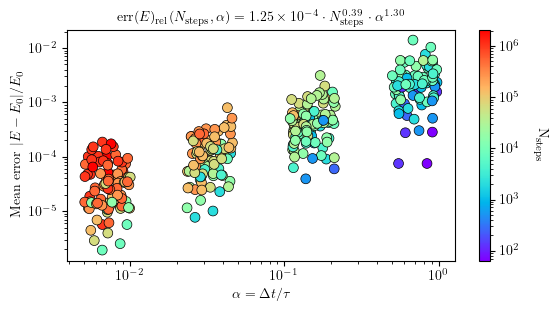

In [91]:
cmap = plt.get_cmap('rainbow')
norm = mpl.colors.LogNorm(vmin=np.min(NSTEPS), vmax=np.max(NSTEPS))
colors = cmap(norm(NSTEPS))
fig, ax = plt.subplots(figsize=(8.25-2, 3))
ax.scatter(alphas, meanErrEs, c=colors, s=50, edgecolor='black', linewidth=0.5)
ax.set_xscale('log')
ax.set_yscale('log')
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label(r"$\mathrm{{N}}_{\mathrm{steps}}$", rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize='medium')
ax.set_ylabel(r"$\mathrm{Mean~error}~|E - E_0| / E_0$")
ax.set_xlabel(r"$\alpha = \Delta t / \tau$")
ax.set_title(compstring, fontsize='medium')
fig.savefig("../../images/NumericalErrorStreamRetraceEnergyConservation.png", bbox_inches='tight', dpi=300)